In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import math
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

from jax import random
from numpyro.infer import MCMC, NUTS

import numpyro.distributions as dist

import arviz as az

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# N_t: number of times data is detected by each detector; N_p: number of pixels
# signal: data of signal (which in this case is modeled to be a sine function in each pixel)

N_t, N_p = 150 * 10, 10

signal = np.random.uniform(low=5, high=30, size=2*N_p) # twice the pixels because the signal is moving

In [ ]:
class Wind:
    def __init__(self, speed, direction):
        self.speed = speed # a function over time
        self.direction = direction # a tuple in the form of (x,y)

    def angle(self): # the angle between the velocity and the east-west direction
        theta = math.atan2(self.direction[1], self.direction[0])
        return theta
    
    def velocity(self):
        x = self.speed * math.cos(self.angle)
        y = self.speed * math.sin(self.angle)
        return (x,y)

In [ ]:
class Signal:
    def moving_velocity(self, wind):
        vel = wind.velocity()
        return vel

    def signal_func(self, time, wind): # one dimensional
        signal_t = []
        vel = self.moving_velocity(wind)
        for i in range(N_p):
            signal_t.append(self[i-time*vel])
        signal_t = np.array(signal_t)
        return signal_t

In [ ]:
wind = Wind(1, (-1,0))

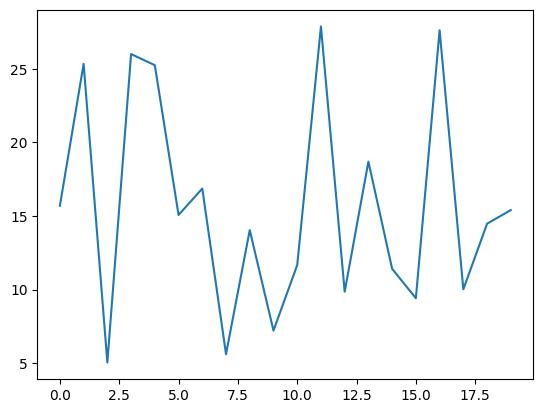

In [4]:
plt.plot(signal)

In [5]:
# the original pointing matrix
P_encoded_org = list()
for row in range(N_t):
    for col in range(N_p):
            if ((row / 150) // (10 / 10) == col):
                P_encoded_org.append(col)
          
P_encoded_org = np.array(P_encoded_org)
print(np.shape(P_encoded_org))

# the pointing matrix adjusted for the shifting signal
P_encoded = list()
for row in range(N_t):
    for col in range(N_p*2):
            if ((row / 150) // (10 / 20) == col):
                P_encoded.append(col)        
P_encoded = np.array(P_encoded)
print(np.shape(P_encoded))

(1500,)
(1500,)


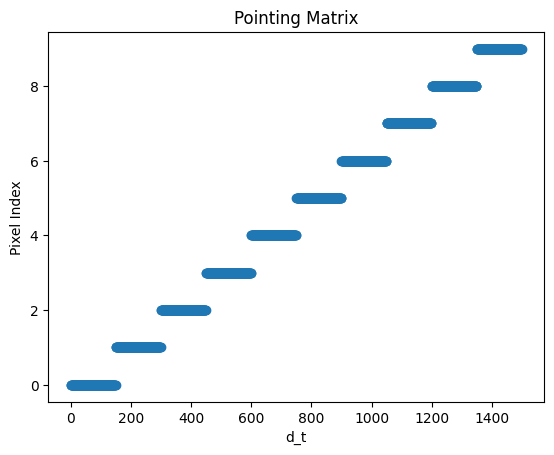

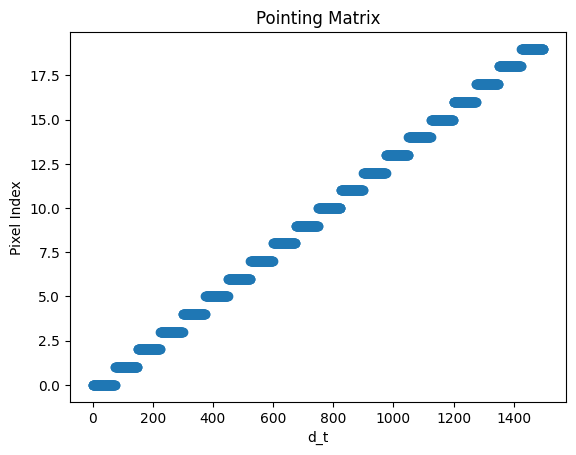

In [6]:
# check P_encoded

plt.scatter(range(len(P_encoded_org)), P_encoded_org)
plt.xlabel("d_t")
plt.ylabel("Pixel Index")
plt.title("Pointing Matrix")
plt.show()

plt.scatter(range(len(P_encoded)), P_encoded)
plt.xlabel("d_t")
plt.ylabel("Pixel Index")
plt.title("Pointing Matrix")
plt.show()

In [7]:
input = signal[P_encoded]
print(np.shape(input))

(1500,)


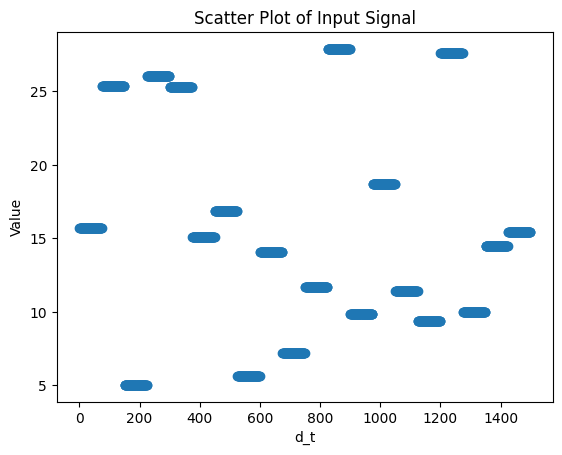

In [8]:
# Scatter Plot of Input Signals

plt.scatter(range(len(input)), input)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

In [9]:
# Creating noisy data

noise_1 = np.random.randn(N_t) * 10
noise_2 = np.random.randn(N_t) * 50

print(np.shape(noise_1))

Data_small_noise = input + noise_1
Data_large_noise = input + noise_2

(1500,)


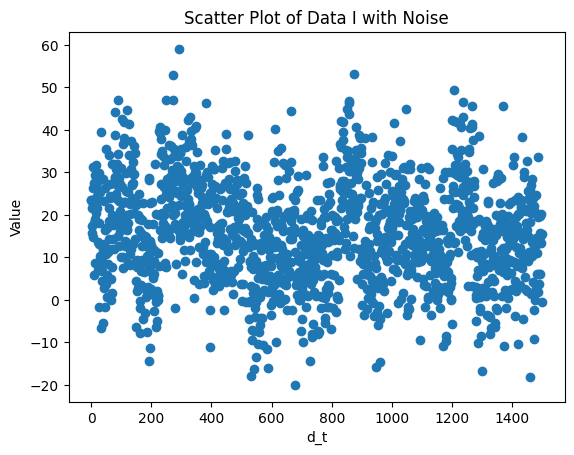

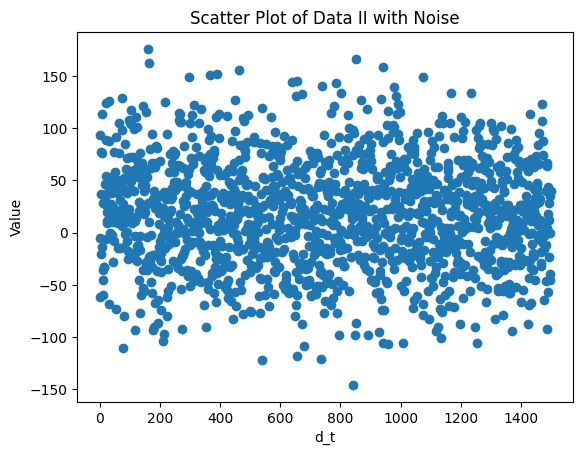

In [10]:
# Scatter Plot of Data

plt.scatter(range(len(Data_small_noise)), Data_small_noise)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data I with Noise")
plt.show()

plt.scatter(range(len(Data_large_noise)), Data_large_noise)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data II with Noise")
plt.show()

In [11]:
def model_func_1():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p*2,-30), high=jnp.full(N_p*2,100)))
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_small_noise)
        return d_noised

rng_key = random.PRNGKey(0)
nuts_kernel_1 = NUTS(model_func_1)
mcmc_1 = MCMC(nuts_kernel_1, num_warmup=100, num_samples=100)
mcmc_1.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 371.01it/s, 3 steps of size 8.42e-01. acc. prob=0.72]


In [12]:
def model_func_2():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p*2,0), high=jnp.full(N_p*2,100)))
        # d = PM_converted @ s
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,50.), obs=Data_large_noise)
        return d_noised

rng_key = random.PRNGKey(0)
nuts_kernel_2 = NUTS(model_func_2)
mcmc_2 = MCMC(nuts_kernel_2, num_warmup=100, num_samples=100)
mcmc_2.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 458.84it/s, 15 steps of size 3.28e-01. acc. prob=0.92]


In [13]:
trace_1 = az.from_numpyro(mcmc_1)
trace_2 = az.from_numpyro(mcmc_2)

(1500,)
(1500,)
(1500,)
(1500,)


In [14]:
trace_1.posterior['s'].squeeze().shape
trace_2.posterior['s'].squeeze().shape

(100, 20)

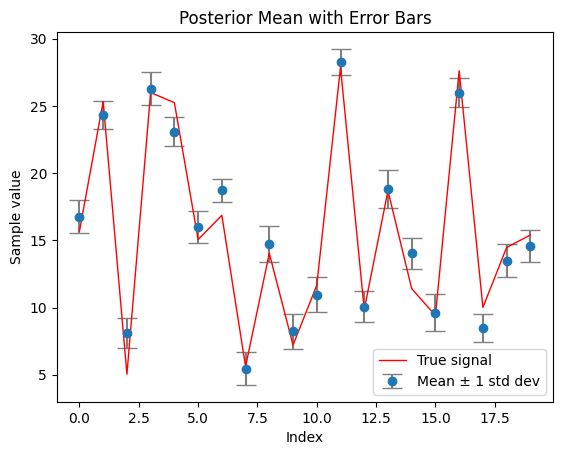

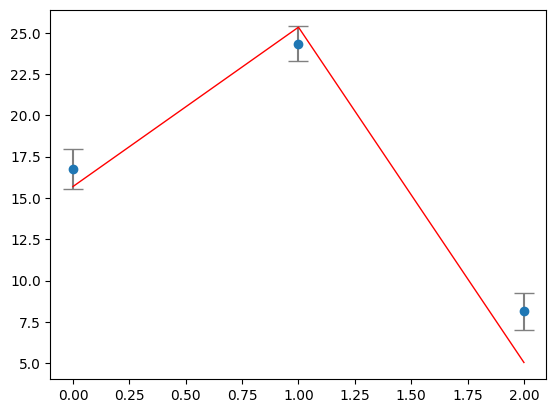

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_33873/1629261974.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


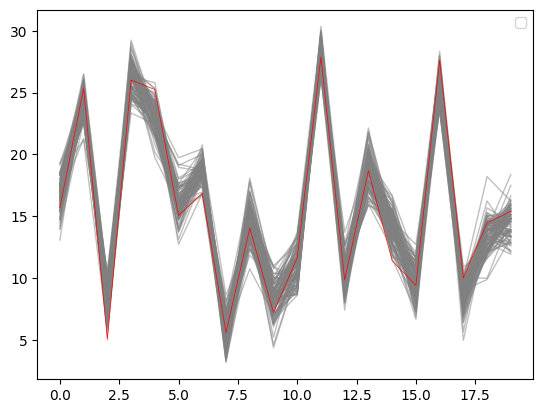

In [15]:
s_samples_1 = trace_1.posterior['s'].squeeze().values
s_mean_1 = np.mean(s_samples_1, axis=0)
s_std_1 = np.std(s_samples_1, axis=0)

x = np.arange(len(s_mean_1))

plt.errorbar(x, s_mean_1, yerr=s_std_1, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:3], s_mean_1[0:3], yerr=s_std_1[0:3], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal[0:3], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_1.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

In [15]:
# # converting the signals back to N_r * (N_p + 1) arrays

# s_mean_1 = s_mean_1.reshape(N_r,N_p*2)
# print(np.shape(s_mean_1))

In [16]:
# plt.imshow(s_mean_1, aspect='equal', cmap='viridis') 
# plt.colorbar(label='Value')
# plt.xlabel('Pixel Column')
# plt.ylabel('Pixel Row')
# plt.title('2D Visualization of the Mean of the Sample Signals')
# plt.show()

# plt.imshow(s_mean_1 - signal, aspect='equal', cmap='viridis') 
# plt.colorbar(label='Value')
# plt.xlabel('Pixel Column')
# plt.ylabel('Pixel Row')
# # plt.title('2D Visualization of the Difference btw the Mean of the Sample Signals and the Original Signal')
# plt.show()

# plt.imshow(s_mean_1 - signal, aspect='equal', cmap='viridis', vmin=0, vmax=30) 
# plt.colorbar(label='Value')
# plt.xlabel('Pixel Column')
# plt.ylabel('Pixel Row')
# # plt.title('2D Visualization of the Difference btw the Mean of the Sample Signals and the Original Signal')
# plt.show()

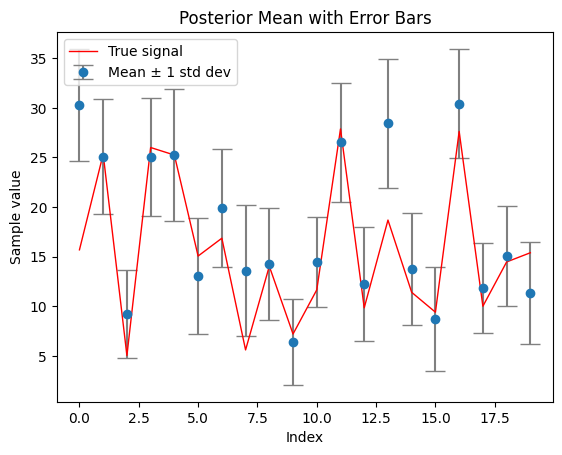

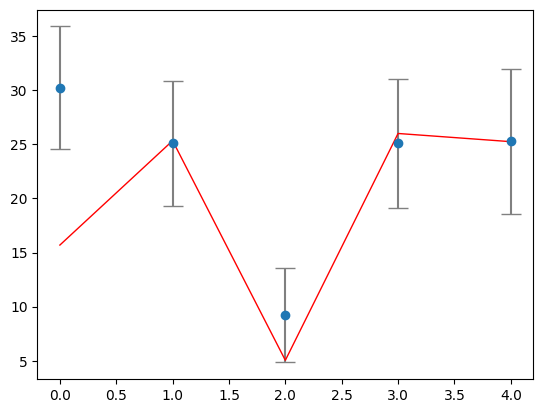

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_33873/937641132.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


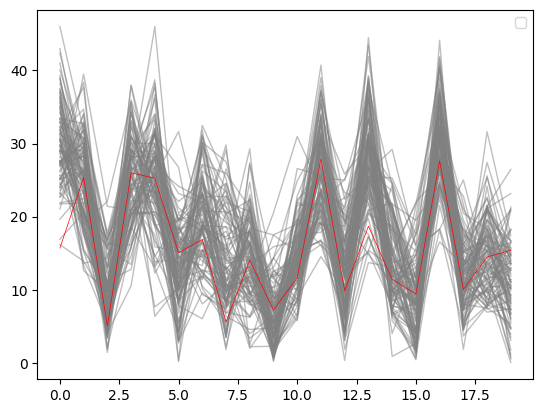

In [16]:
s_samples_2 = trace_2.posterior['s'].squeeze().values  # shape: (100, 25)
s_mean_2 = np.mean(s_samples_2, axis=0)                  # shape: (25,)
s_std_2 = np.std(s_samples_2, axis=0)                    # shape: (25,)

x = np.arange(len(s_mean_2))

plt.errorbar(x, s_mean_2, yerr=s_std_2, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:5], s_mean_2[0:5], yerr=s_std_2[0:5], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal[:5], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_2.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

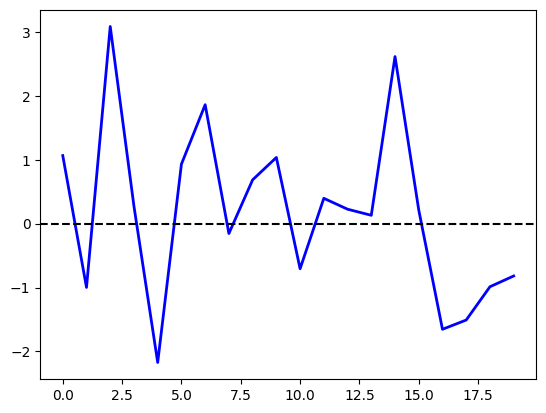

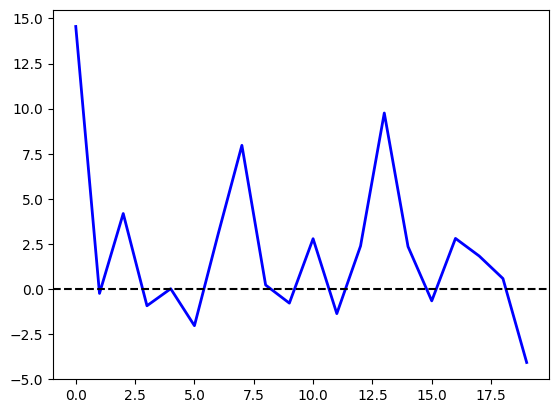

In [17]:
plt.plot(s_mean_1 - signal, color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

plt.plot(s_mean_2 - signal, color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [56]:
np.shape(signal)
velocity = -1

In [88]:
def signal_func(sig, time, vel):
    signal_t = []
    for i in range(N_p):
        signal_t.append(sig[i-time*vel])
    signal_t = np.array(signal_t)
    return signal_t

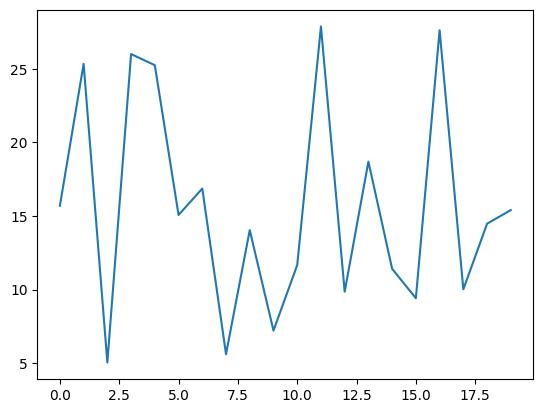

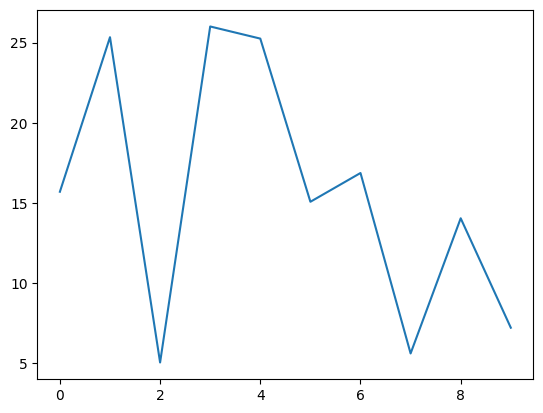

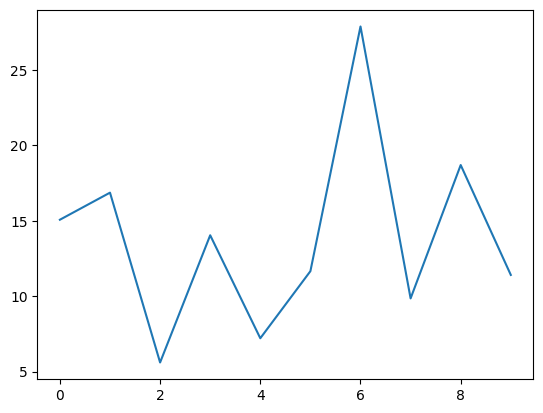

In [59]:
plt.plot(signal)
plt.show()
plt.plot(signal_func(signal, 0, velocity))
plt.show()
plt.plot(signal_func(signal, 5, velocity))
plt.show()

In [89]:
input_2 = []
for time_ind in range(N_t):
    output = signal_func(signal, time_ind//150, velocity)
    # print(np.shape(output))
    input_2.append(output[P_encoded_org][time_ind])
input_2 = np.array(input_2)

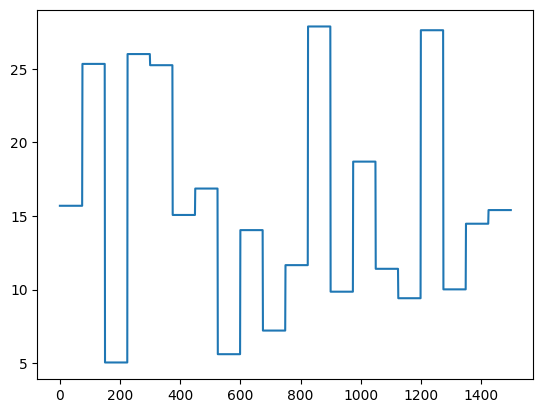

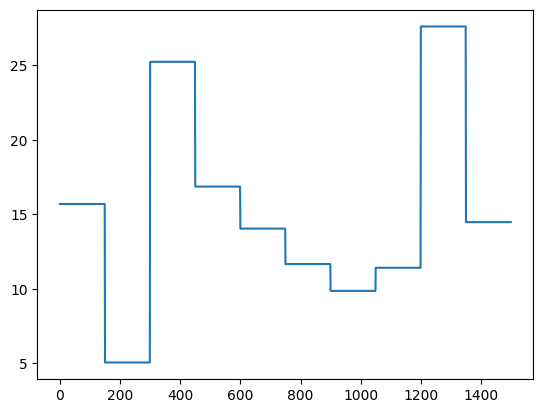

In [82]:
plt.plot(input)
plt.show()
plt.plot(input_2)

In [21]:
print(np.shape(input_2))

(1500,)


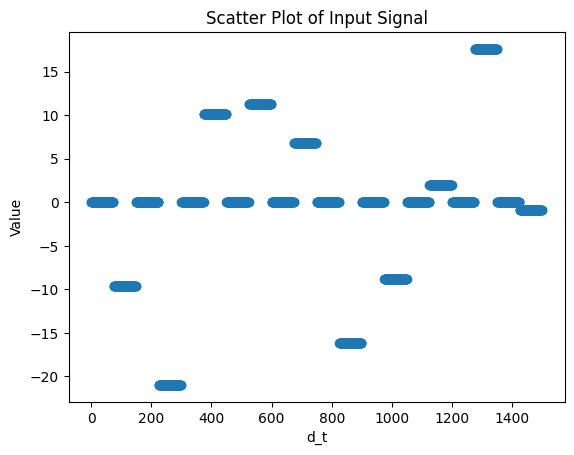

In [22]:
plt.scatter(range(len(input)), input_2-input)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

In [29]:
# Creating noisy data

Data_small_noise_2 = input_2 + noise_1
Data_large_noise_2 = input_2 + noise_2

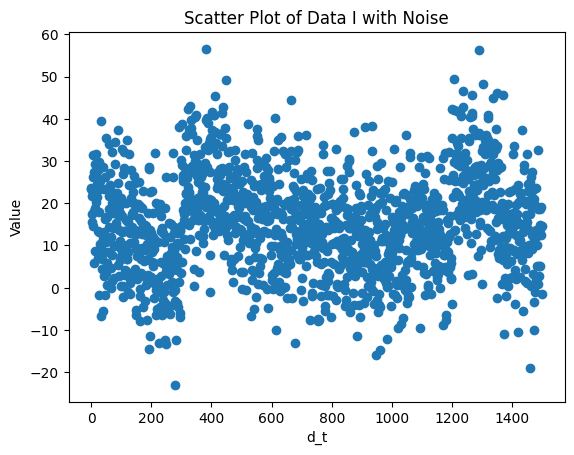

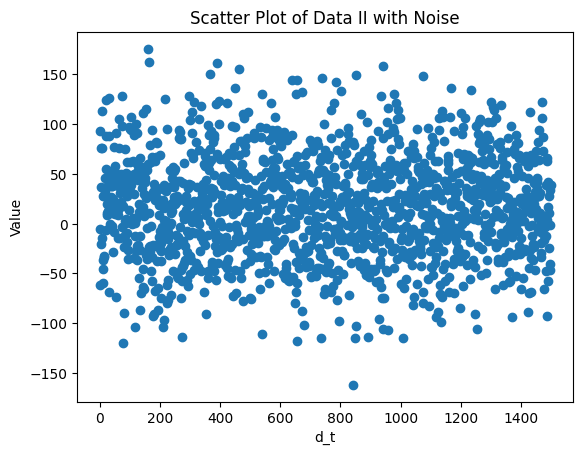

In [30]:
# Scatter Plot of Data

plt.scatter(range(len(Data_small_noise_2)), Data_small_noise_2)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data I with Noise")
plt.show()

plt.scatter(range(len(Data_large_noise_2)), Data_large_noise_2)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data II with Noise")
plt.show()

In [90]:
def model_func_3():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p,-30), high=jnp.full(N_p,100)))
        d = s[P_encoded_org]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_small_noise_2)
        return d_noised

# rng_key = random.PRNGKey(0)
nuts_kernel_3 = NUTS(model_func_3)
mcmc_3 = MCMC(nuts_kernel_3, num_warmup=100, num_samples=100)
mcmc_3.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 298.04it/s, 3 steps of size 7.31e-01. acc. prob=0.84]


In [91]:
def model_func_4():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p,-100), high=jnp.full(N_p,100)))
        # d = PM_converted @ s
        d = s[P_encoded_org]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,50.), obs=Data_large_noise_2)
        return d_noised

# rng_key = random.PRNGKey(0)
nuts_kernel_4 = NUTS(model_func_4)
mcmc_4 = MCMC(nuts_kernel_4, num_warmup=100, num_samples=100)
mcmc_4.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 449.50it/s, 7 steps of size 4.85e-01. acc. prob=0.93]


In [92]:
trace_3 = az.from_numpyro(mcmc_3)
trace_4 = az.from_numpyro(mcmc_4)

(1500,)
(1500,)
(1500,)
(1500,)


In [93]:
trace_3.posterior['s'].squeeze().shape
trace_4.posterior['s'].squeeze().shape

(100, 10)

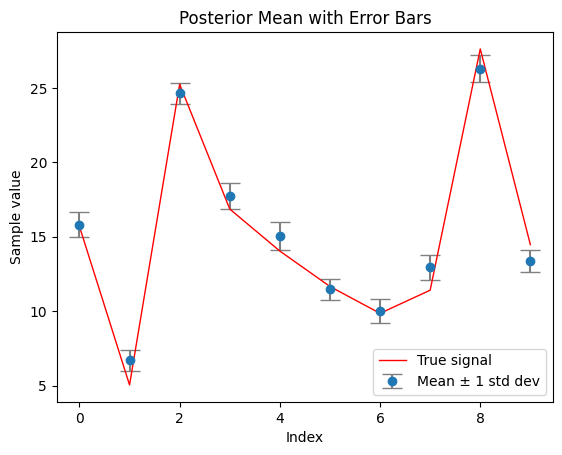

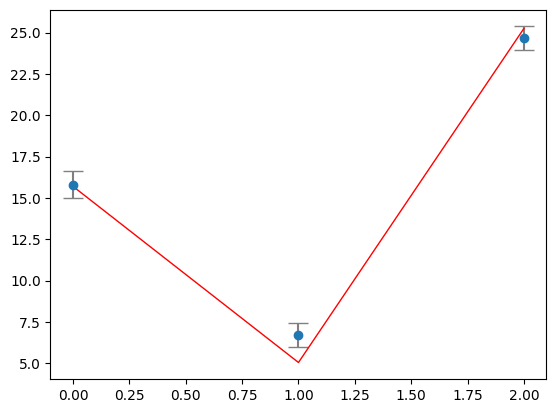

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_33873/1613277044.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


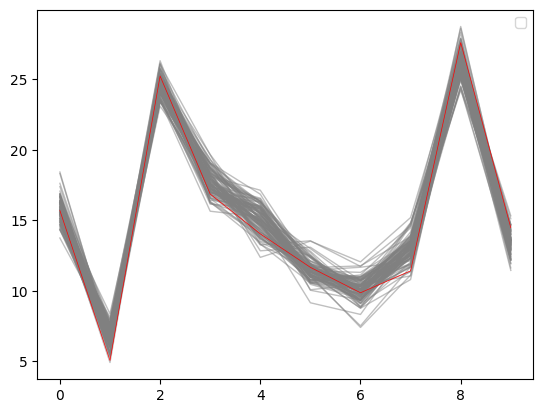

In [94]:
s_samples_3 = trace_3.posterior['s'].squeeze().values
s_mean_3 = np.mean(s_samples_3, axis=0)
s_std_3 = np.std(s_samples_3, axis=0)

signal_2 = []
for i in range(len(signal)):
    if (i % 2 == 0):
        signal_2.append(signal[i])

x = np.arange(len(s_mean_3))

plt.errorbar(x, s_mean_3, yerr=s_std_3, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:3], s_mean_3[0:3], yerr=s_std_3[0:3], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2[0:3], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_3.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal_2, color='red', lw=0.5)
plt.legend()
plt.show()

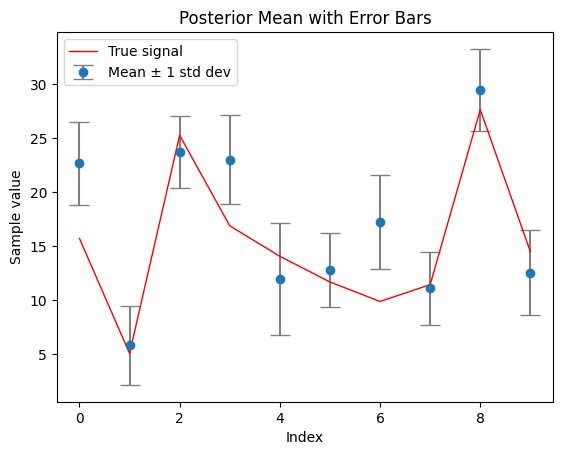

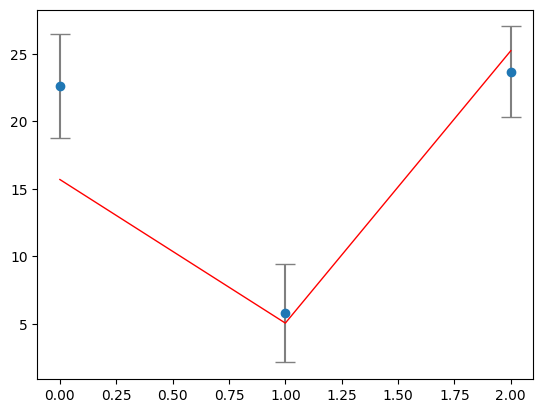

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_33873/2440125995.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


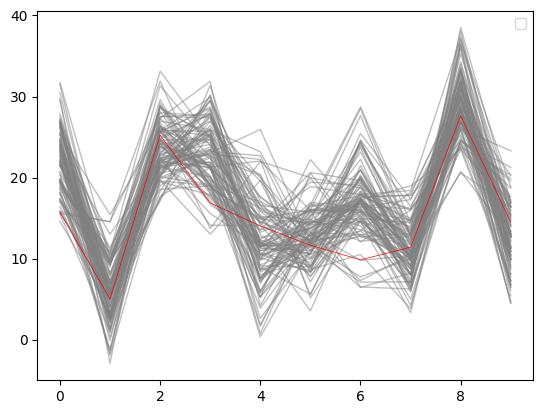

In [95]:
s_samples_4 = trace_4.posterior['s'].squeeze().values
s_mean_4 = np.mean(s_samples_4, axis=0)
s_std_4 = np.std(s_samples_4, axis=0)

x = np.arange(len(s_mean_4))

plt.errorbar(x, s_mean_4, yerr=s_std_4, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:3], s_mean_4[0:3], yerr=s_std_4[0:3], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2[0:3], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_4.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal_2, color='red', lw=0.5)
plt.legend()
plt.show()